In [1]:
########################################################### IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary, set_trainable
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import sys
sys.path.append('../src')
from data_preparation import get_birth_data, separate_data, separate_data_with_monday_flag

tf.keras.backend.set_floatx("float64")


In [3]:
tf.keras.backend.set_floatx("float64")

data = get_birth_data()
x, y, m = separate_data_with_monday_flag(data, normalised=True)
# x_w, y_w = separate_data(data, normalised=True, weekdays=True)

x = x.numpy()
y = y.numpy()
m = m.numpy()

def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs

pos, labels = get_xticks(data)

In [60]:
def plot_distribution(X, Y, loc, scale, pos, labels, CI=None):
    plt.figure(figsize=(25, 7))
    x = X.squeeze()

    if CI:
        lb = (loc - 1.96 * scale).squeeze()
        ub = (loc + 1.96 * scale).squeeze()

        plt.fill_between(x, lb, ub, color="C0", alpha=0.4)
    #plt.plot(x, lb, color="C0")
    #plt.plot(x, ub, color="C0")
    plt.plot(X, Y, '.', color="black", alpha=0.5, markersize=3)
    plt.plot(X, loc, color="C0")

    plt.title('EXP(GP)  --- Amazing!!!')
    plt.xticks(pos, labels)
    plt.xlabel('Date')
    plt.ylabel('Births')
    
    plt.show()
    plt.close()

In [57]:
from typing import Any, Optional, Type

import tensorflow as tf
import tensorflow_probability as tfp

from gpflow.utilities import positive
from gpflow.base import TensorType
from gpflow.likelihoods.multilatent import MultiLatentTFPConditional

class CustomTFPConditional(MultiLatentTFPConditional):
    """
    Heteroskedastic Likelihood where the conditional distribution
    is given by a TensorFlow Probability Distribution.
    The `loc` and `scale` of the distribution are given by a
    two-dimensional multi-output GP.
    """

    def __init__(
        self,
        distribution_class: Type[tfp.distributions.Distribution] = tfp.distributions.Normal,
        loc_transform: Optional[tfp.bijectors.Bijector] = None,
        monday_flag = None,
        **kwargs: Any,
    ) -> None:
        """
        :param distribution_class: distribution class parameterized by `loc` and `scale`
            as first and second argument, respectively.
        :param scale_transform: callable/bijector applied to the latent
            function modelling the scale to ensure its positivity.
            Typically, `tf.exp` or `tf.softplus`, but can be any function f: R -> R^+. Defaults to exp if not explicitly specified.
        """

        if loc_transform is None:
            loc_transform = tfp.bijectors.Identity()
        self.loc_transform = loc_transform
        self.monday_flag = monday_flag

        def conditional_distribution(Fs: TensorType) -> tfp.distributions.Distribution:
            tf.debugging.assert_equal(tf.shape(Fs)[-1], 2)
        
            scale_transform = positive(base="exp")
            scale = scale_transform(Fs[..., 1:])

            dist = tfd.Normal(loc=0., scale=1.)
            rsample = dist.sample([self.monday_flag.shape[0]])   
            rsample = tf.reshape(tf.cast(rsample, dtype=tf.float64), (rsample.shape[0],1))
            beta = tf.where(self.monday_flag == 1, rsample, 0)
            # (400, 7305, 2) = Fs.shape
            
            loc = Fs[..., :1] + beta * self.loc_transform(Fs[..., :1])
            return distribution_class(loc, scale)

        super().__init__(
            latent_dim=2,
            conditional_distribution=conditional_distribution,
            **kwargs,
        )

Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19
Epoch  20
Epoch 20 - Loss:  20119.0816


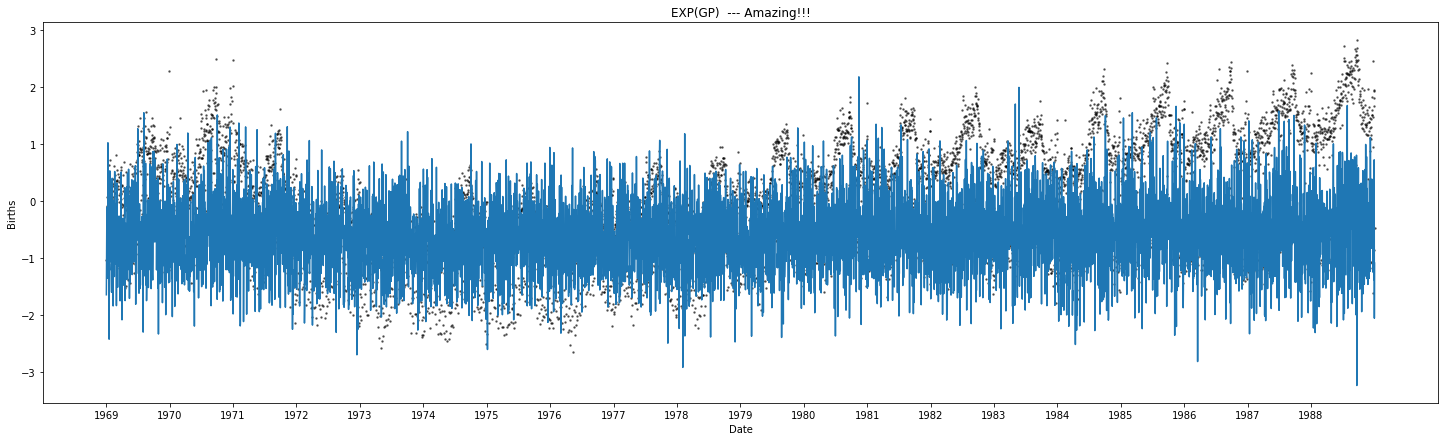

Epoch  21
Epoch  22
Epoch  23
Epoch  24
Epoch  25
Epoch  26
Epoch  27
Epoch  28
Epoch  29
Epoch  30
Epoch  31
Epoch  32
Epoch  33
Epoch  34
Epoch  35
Epoch  36
Epoch  37
Epoch  38
Epoch  39
Epoch  40
Epoch 40 - Loss:  16731.3425


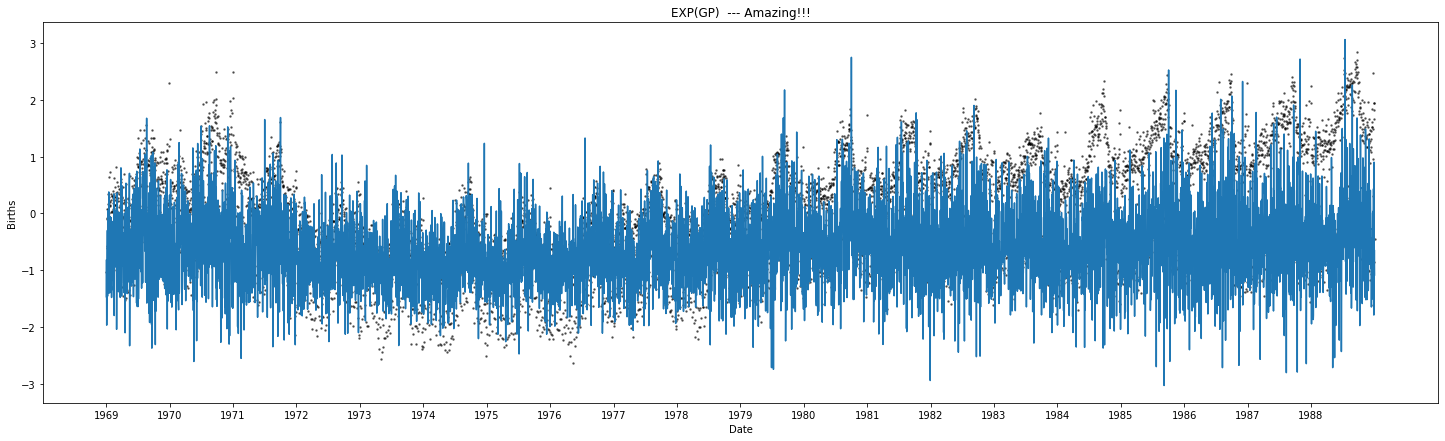

Epoch  41
Epoch  42
Epoch  43
Epoch  44
Epoch  45
Epoch  46
Epoch  47
Epoch  48
Epoch  49
Epoch  50
Epoch  51
Epoch  52
Epoch  53
Epoch  54
Epoch  55
Epoch  56
Epoch  57
Epoch  58
Epoch  59
Epoch  60
Epoch 60 - Loss:  15598.4264


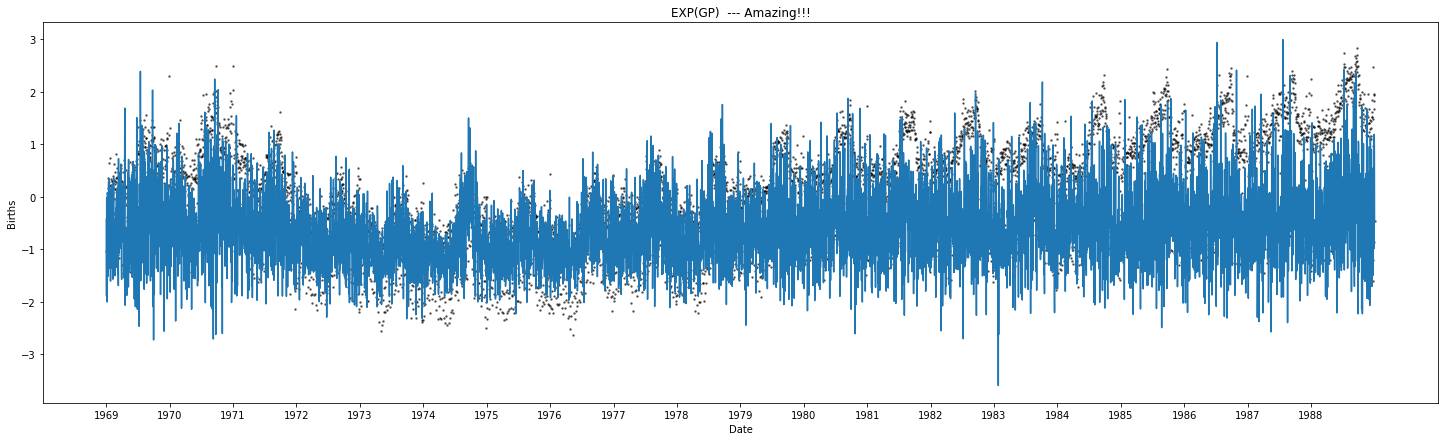

Epoch  61
Epoch  62
Epoch  63
Epoch  64
Epoch  65
Epoch  66
Epoch  67
Epoch  68
Epoch  69
Epoch  70
Epoch  71
Epoch  72
Epoch  73
Epoch  74
Epoch  75
Epoch  76
Epoch  77
Epoch  78
Epoch  79
Epoch  80
Epoch 80 - Loss:  14975.5365


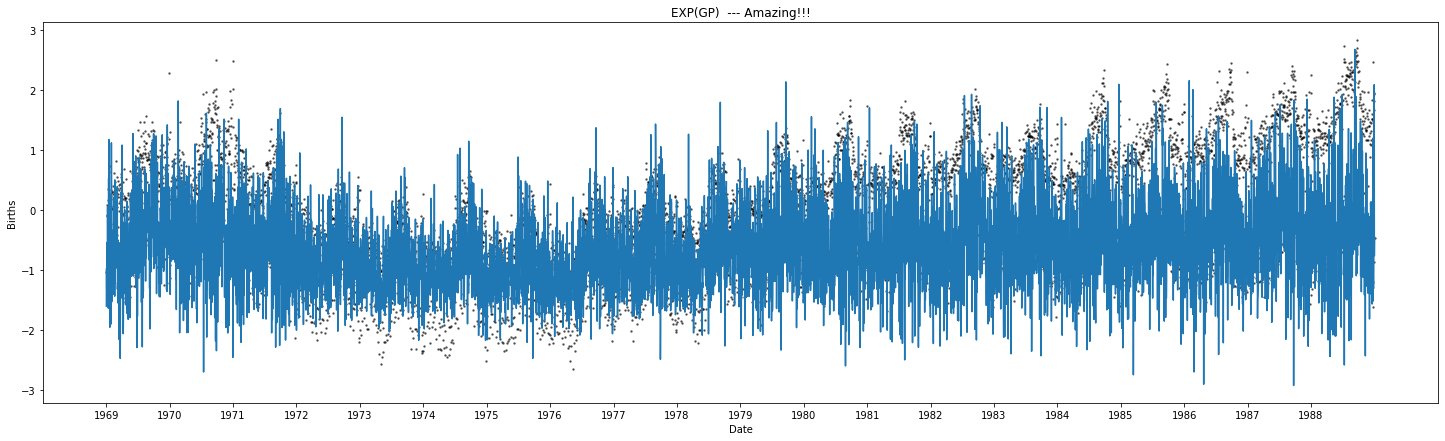

Epoch  81
Epoch  82
Epoch  83
Epoch  84
Epoch  85
Epoch  86
Epoch  87
Epoch  88
Epoch  89
Epoch  90
Epoch  91
Epoch  92
Epoch  93
Epoch  94
Epoch  95
Epoch  96
Epoch  97
Epoch  98
Epoch  99
Epoch  100
Epoch 100 - Loss:  14530.5867


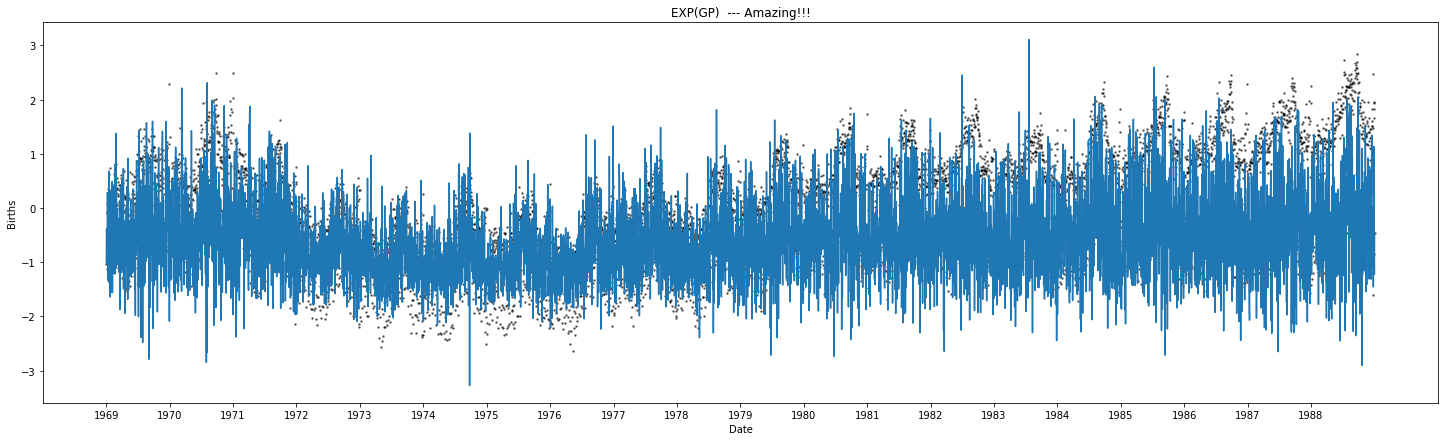

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].kernels[0].variance,Parameter,Softplus,,True,(),float64,0.5373059382712703
SVGP.kernel.kernels[0].kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.486949623447051
SVGP.kernel.kernels[0].kernels[1].base_kernel.variance,Parameter,Softplus,,True,(),float64,1.2103290963076785
SVGP.kernel.kernels[0].kernels[1].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0085697721605689
SVGP.kernel.kernels[0].kernels[1].period,Parameter,Softplus,,False,(),float64,365.25
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.5547230002037387
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.411938716915267
SVGP.inducing_variable.inducing_variable_list[0].Z,Parameter,Identity,,True,"(3000, 1)",float64,[[1.23650946e+00...
SVGP.inducing_variable.inducing_variable_list[1].Z,Parameter,Identity,,True,"(3000, 1)",float64,[[1.43864726e+00...
SVGP.q_mu,Parameter,Identity,,False,"(3000, 2)",float64,"[[-0.50431878, -0.13967751..."


In [65]:
likelihood = CustomTFPConditional(
    distribution_class = tfp.distributions.Normal, 
    loc_transform = tfp.bijectors.Exp(), 
    monday_flag = m,
)

#### jitter
kernel = gpflow.kernels.SeparateIndependent(
    [
        gpflow.kernels.RBF() + gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25),
        gpflow.kernels.RBF(),  
    ]
)


M = 3000  
Z = np.linspace(x.min(), x.max(), M)[:, None]  # [M, 1]

inducing_variable = gpflow.inducing_variables.SeparateIndependentInducingVariables(
    [
        gpflow.inducing_variables.InducingPoints(Z),  
        gpflow.inducing_variables.InducingPoints(Z),  
    ]
)

model = gpflow.models.SVGP(
    kernel=kernel,
    likelihood=likelihood,
    inducing_variable=inducing_variable,
    num_latent_gps=likelihood.latent_dim,
    #whiten=False
)

##############################################################################################

data = (x, y)
loss_fn = model.training_loss_closure(data) 

gpflow.utilities.set_trainable(model.q_mu, False)
gpflow.utilities.set_trainable(model.q_sqrt, False)
set_trainable(model.kernel.kernels[0].kernels[1].period, False)
#gpflow.utilities.set_trainable(model.likelihood.variance, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)

@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

epochs = 100
log_freq = 20

for epoch in range(1, epochs + 1):
    print('Epoch ', epoch)
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        Ymean, Yvar = model.predict_y(x)
        Ymean = Ymean.numpy().squeeze()
        Ystd = tf.sqrt(Yvar).numpy().squeeze()
        plot_distribution(x, y, Ymean, Ystd, pos, labels)

model